In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt, lfilter
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Reshape, Permute
from keras.utils import to_categorical
from tensorflow import keras
import pywt
import scipy.signal as signal
from scipy.integrate import simps

import scipy

In [4]:
# ---------- FUNCTIONS ---------- #

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def extract_features(coeffs):
    features = []
    for coeff in coeffs:
        features.extend([np.mean(coeff**2), np.std(coeff)])
    return features


def apply_wavelet_transform(data, wavelet='db4', level=5):
    # Apply wavelet transform to each sensor's data
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Concatenate the coefficients into a single array
    wavelet_transformed = np.hstack(coeffs)
    return wavelet_transformed


def apply_scaling(array):
  # print("array scaling", array.shape)
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm


def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 12
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 12
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y


def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y

def extract_frequency_bands(data, fs):
    # Define the frequency bands
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 80)}

    # Initialize the output
    extracted_features = np.zeros((data.shape[0], 25))  # 248 sensors, 5 bands * 5 features

    for sensor_index in range(data.shape[0]):
        sensor_data = data[sensor_index, :]

        features = []
        for band in bands.values():
            # Apply bandpass filter
            band_data = bandpass_filter(sensor_data, band[0], band[1], fs=fs)

            # Calculate statistical features
            features.append(np.mean(band_data))
            features.append(np.std(band_data))
            features.append(scipy.stats.skew(band_data))
            features.append(scipy.stats.kurtosis(band_data))
            features.append(np.sum(np.square(band_data)))  # Energy

        extracted_features[sensor_index, :] = features

    return extracted_features


In [5]:
# LOAD FILES

# Helper function to get file paths and labels
def get_file_paths_and_labels(data_folder, task_numbers):
  file_paths = []
  labels = []
  for task_number in task_numbers:
      for file in os.listdir(data_folder):
          if file.endswith(task_number + 'h5'):
              file_path = os.path.join(data_folder, file)
              file_paths.append(file_path)
              labels.append(assign_label(file))
  return file_paths, labels

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def load_data(file_path):
  with h5py.File(file_path, 'r') as f:
      dataset_name = get_dataset_name(file_path)
      matrix = f.get(dataset_name)[:]
      return matrix

def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name

def assign_label(file_name):
  if file_name.startswith("rest"):
      return 0
  elif file_name.startswith("task_motor"):
      return 1
  elif file_name.startswith("task_story"):
      return 2
  elif file_name.startswith("task_working"):
      return 3
  else:
      return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files

In [6]:
def build_ffnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(16, activation='relu'))  # First hidden layer
    # model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(32, activation='relu'))  # Second hidden layer
    # model.add(Dropout(0.5))  # Another dropout layer
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# ------------------------------ Train Data ------------------------------ #

In [8]:
def meg_data_generator(data_folder, task_numbers, batch_size):
  while True:
    for task in task_numbers:
        file_paths, labels = get_file_paths_and_labels(data_folder, task)
        for i in range(0, len(file_paths), batch_size):
          print("__________________________________________________*** NEW BATCH ***__________________________________________________")
          batch_paths = file_paths[i:i + batch_size]
          batch_labels = labels[i:i + batch_size]
          print(batch_labels)
          batch_data = []
          for i, path in enumerate(batch_paths):
            print(f"\n*** {i+1}/{batch_size} file is being processed ***")
            data = load_data(path)
            data = preprocess_data(data)  # scaling, filtering, downsampling.
            batch_data.append(data)


          del data
          # Reshape and concatenate data from each file in the batch
          batch_data = np.concatenate(batch_data, axis=0)  # Shape becomes (4*248, 8906)
          batch_data = np.expand_dims(batch_data, axis=-1)  # Add an extra dimension at the end

          # Prepare labels (assumes labels are replicated for each sensor within a file)
          batch_labels = np.repeat(batch_labels, 248, axis=0)  # Replicate labels for each sensor
          batch_labels = to_categorical(batch_labels, num_classes=4)
          # batch_labels = np.expand_dims(batch_labels, axis=-1)

          print("\n!!! FILES WERE LOADED. DATA SHAPE:", batch_data.shape, ", LABELS SHAPE:",batch_labels.shape, "!!!\n")
          yield batch_data, batch_labels


# Include your preprocessing steps here
def preprocess_data(data):
  data = data[:, :-8]
  data = apply_scaling(data)
  print("- scaling applied . . . shape:", data.shape)
  data = apply_lowpass(data)
  print("- lowpass applied . . . shape:", data.shape)
  data = apply_downsampling(data)
  print("- downsam applied . . . shape:", data.shape)
  bands_data = extract_frequency_bands(data, 2034/12)
  print(bands_data[0])
  print("- Data after extracting features:", np.array(bands_data).shape)
  del data
  return np.array(bands_data)


fmri_data_folder = find_fmri_data_folder('/content/drive')
print("fmri_data_folder:", fmri_data_folder)
task_numbers = ['_1.','_2.','_3.','_4.','_5.','_6.','_7.','_8.']
batch_size = 32
epochs = 4

# Initialize model here
model = build_ffnn_model((25,1), 4)

# Create data generator
train_generator = meg_data_generator(fmri_data_folder, task_numbers, batch_size)
print("train_generator", train_generator)


# Determine the number of steps per epoch
total_files = count_files_with_task_numbers(fmri_data_folder, task_numbers)
print(total_files)
steps_per_epoch = total_files // batch_size

# Train the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)


fmri_data_folder: /content/drive/.shortcut-targets-by-id/12woTG1TRZVOuuOVm6KXBkIIxROFpmg72/meg_data/Intra/train
train_generator <generator object meg_data_generator at 0x7956f45e9070>
32
__________________________________________________*** NEW BATCH ***__________________________________________________
[2, 3, 1, 1, 2, 0, 3, 1, 2, 3, 3, 2, 0, 0, 0, 2, 1, 3, 2, 2, 2, 0, 0, 0, 1, 1, 3, 1, 3, 1, 0, 3]

*** 1/32 file is being processed ***
- scaling applied . . . shape: (248, 35616)
- lowpass applied . . . shape: (248, 35616)
- downsam applied . . . shape: (248, 2968)
[-3.73956935e-03  3.12956158e-01 -1.89553525e-01  7.27263002e-01
  2.90732047e+02 -7.33330310e-04  2.23147927e-01  1.36033600e-02
  1.93677565e+00  1.47793148e+02  1.07328088e-04  1.69900128e-01
 -1.67765838e-03  6.76120739e-02  8.56744806e+01  2.94668234e-04
  2.84924923e-01  1.10498089e-02  9.09288154e-01  2.40949063e+02
 -8.20916654e-05  2.07270611e-01  3.66503454e-02  1.28331754e-01
  1.27508583e+02]
- Data after extracti

In [ ]:
# ------------------------------ Test data ------------------------------ #

In [ ]:
# Retrieve Test data

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        # print(file_name, "REST")
        return 0
    elif file_name.startswith("task_motor"):
        # print(file_name, "MOTOR")
        return 1
    elif file_name.startswith("task_story"):
        # print(file_name, "STORY")
        return 2
    elif file_name.startswith("task_working"):
        # print(file_name, "WORKING")
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

meg_test_data_array = meg_test_data_array[:, :, :-8]


def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1],array.shape[2]))
  for i in range(array.shape[0]):
    means = np.mean(array[i], axis=1)  # Calculate mean for each sensor
    stds = np.std(array[i], axis=1)    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means[:, np.newaxis]) / stds[:, np.newaxis]   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 12
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered

def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  downsampling_factor = 12
  new_n_timepoints = n_timepoints // downsampling_factor

  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp

def apply_wavelet_transform(data, wavelet='db4', level=5):
    # Apply wavelet transform to each sensor's data
    transformed_data = []
    for sensor_data in data:
        coeffs = pywt.wavedec(sensor_data, wavelet, level=level)
        # Find the length of the longest coefficient array
        max_len = max(len(coeff) for coeff in coeffs)
        # Pad each coefficient array to the max_len
        padded_coeffs = [np.pad(coeff, (0, max_len - len(coeff)), 'constant') for coeff in coeffs]
        # Concatenate the padded coefficients into a single array
        wavelet_transformed = np.hstack(padded_coeffs)
        transformed_data.append(wavelet_transformed)
    return np.array(transformed_data)

def extract_features_from_multiple_instances(data):
    # data shape expected: (1984, 3001)
    num_instances, num_points = data.shape
    num_features = 2  # Mean squared and standard deviation

    # Initialize an array to hold the extracted features for all instances
    features_array = np.zeros((num_instances, num_features * num_points))

    for instance_index in range(num_instances):
        instance_data = data[instance_index, :]
        # Extract features for this instance
        features = np.array([np.mean(instance_data**2), np.std(instance_data)])
        # Repeat the features for the length of the data
        repeated_features = np.tile(features, num_points)
        features_array[instance_index, :] = repeated_features

    return features_array


X_task_norm = apply_scaling(meg_test_data_array)
print("- scaling applied . . . shape:", X_task_norm.shape)
del meg_test_data_array
gc.collect()

# Lowpass filter
X_task_filtered = apply_lowpass(X_task_norm)
print("- lowpass applied . . . shape:", X_task_filtered.shape)
del X_task_norm
gc.collect()

# Downsample
X_task_downsamp = apply_downsampling(X_task_filtered)
del X_task_filtered
gc.collect()
print("- downsam applied . . . shape:", X_task_downsamp.shape)

x_task_wavelet = apply_wavelet_transform(X_task_downsamp)
print("- wavelet applied . . . shape:", x_task_wavelet.shape)
del X_task_downsamp

x_task_wavelet_reshaped = x_task_wavelet.reshape(-1,3001) # reshape from (8,248,3001) to (1984,3001)
x_task_features = extract_features_from_multiple_instances(x_task_wavelet_reshaped)
print("- features applied . . . shape:", x_task_features.shape)
del x_task_wavelet



- scaling applied . . . shape: (8, 248, 35616)
- lowpass applied . . . shape: (8, 248, 35616)
- downsam applied . . . shape: (8, 248, 2968)
- wavelet applied . . . shape: (8, 248, 3001)
- features applied . . . shape: (1984, 6002)


In [ ]:
X_test = x_task_features
y_test = to_categorical(labels_test_array, num_classes=4)
y_test = np.repeat(y_test, 248, axis=0)

del x_task_features

In [ ]:
X_test.shape

(1984, 6002)

In [ ]:
y_test.shape

(1984, 4)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

62/62 [==============================] - 0s 2ms/step - loss: 1.3863 - accuracy: 0.2500


In [ ]:
import numpy as np

# Make predictions for the entire test set
all_predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels_all = np.argmax(all_predictions, axis=1)

# Aggregate predictions for each original test instance
final_predictions = []
for i in range(0, len(predicted_labels_all), 248):  # Iterate over each set of 248 sensors
    # Get the predictions for the current set of sensors
    sensor_predictions = predicted_labels_all[i:i + 248]

    # Find the most frequent prediction
    most_frequent_prediction = np.argmax(np.bincount(sensor_predictions))
    final_predictions.append(most_frequent_prediction)



62/62 [==============================] - 0s 2ms/step


In [ ]:
# Compare with actual labels
actual_labels = np.argmax(y_test, axis=1)

In [ ]:
final_predictions

[2, 2, 2, 2, 2, 2, 2, 2]

In [ ]:
labels_test_array

array([1, 3, 2, 2, 1, 0, 3, 0])

In [ ]:
# Calculate accuracy or other metrics if needed
correct_predictions = np.sum(np.array(final_predictions) == labels_test_array)
accuracy = correct_predictions / len(final_predictions)
print("Aggregated Accuracy:", accuracy)

Aggregated Accuracy: 0.25


In [ ]:
# Print individual comparisons
for i in range(len(labels_test_array)):
    print(f"Original Instance {i}: Actual Label = {actual_labels[i]}, Aggregated Predicted Label = {final_predictions[i]}")

Original Instance 0: Actual Label = 1, Aggregated Predicted Label = 2
Original Instance 1: Actual Label = 1, Aggregated Predicted Label = 2
Original Instance 2: Actual Label = 1, Aggregated Predicted Label = 2
Original Instance 3: Actual Label = 1, Aggregated Predicted Label = 2
Original Instance 4: Actual Label = 1, Aggregated Predicted Label = 2
Original Instance 5: Actual Label = 1, Aggregated Predicted Label = 2
Original Instance 6: Actual Label = 1, Aggregated Predicted Label = 2
Original Instance 7: Actual Label = 1, Aggregated Predicted Label = 2


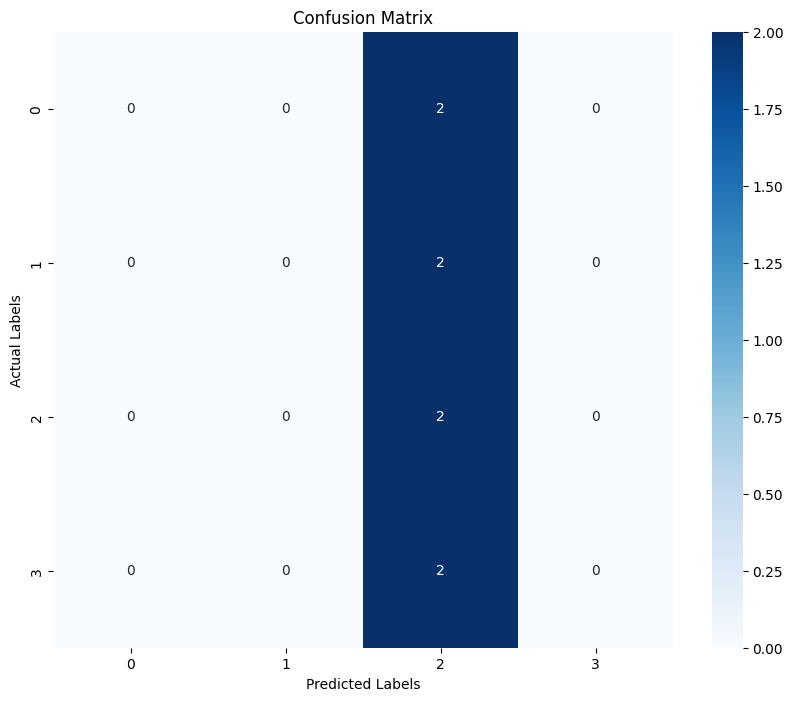

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(labels_test_array, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
'''
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 628ms/step
Sample 0: Actual Label = 1, Predicted Label = 3
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 638ms/step
Sample 1: Actual Label = 3, Predicted Label = 0
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 491ms/step
Sample 2: Actual Label = 2, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 480ms/step
Sample 3: Actual Label = 2, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 482ms/step
Sample 4: Actual Label = 1, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 492ms/step
Sample 5: Actual Label = 0, Predicted Label = 0
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 554ms/step
Sample 6: Actual Label = 3, Predicted Label = 3
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 501ms/step
Sample 7: Actual Label = 0, Predicted Label = 0
'''